# An introduction to computational optimal transport

## Optimal Transport with Entropic Regularisation

$\DeclareMathOperator{\KL}{KL}
\newcommand{\KLdiv}[2]{\KL\pa{#1 \,\vert\, #2}}
\newcommand{\KLproj}{\text{Proj}^{\tiny\KL}}
\renewcommand{\epsilon}{\varepsilon}
\def\ones{\mathbb{I}} $
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This project we solve the discrete optimal transport problem 
problem with the entropic regularisation and Sinkhorn's method for finding the coupling in an iterative manner.

In [1]:
import numpy as np
import scipy.optimize
import scipy.sparse
import matplotlib.pyplot as plt

Consider two dicrete distributions
$$ \al = \sum_{i=1}^n a_i \de_{x_i} \qandq 
   \be = \sum_{j=1}^m b_j \de_{y_j}. $$
   
where $n,m$ are the number of points, $\de_x$ is the Dirac at
location $x \in \RR^d$, and $(x_i)_i, (y_j)_j$ are the positions of the diracs in $\RR^2$.

First we set the number of points $(n,m)$ in the two clouds

In [2]:
n = 10
m = 8

Generate the point clouds $X=(x_i)_i$ and $Y=(y_j)_j$. We go back to normally distributed point locations, but now we will have uniform distribution (this will make the visualisation of the coupling a little cleaner)

In [3]:
np.random.seed(0) # We set the random seed to get the same results each time we run this

X = np.vstack((np.random.normal(loc=[-0.2, 2], scale=0.6, size=(n//2,2)), np.random.normal(loc=[-0.1, -2], scale=1.2, size=(n//2,2))))
print(X.shape)
Y = np.vstack((np.random.normal(loc=[0.2, 1], scale=0.6, size=(m//2,2)), np.random.normal(loc=[0.2, -1], scale=1.2, size=(m//2,2)) ))

normalize = lambda a: a/np.sum(a)

#a = np.ones(n) / n
#b = np.ones(m) / m

a = normalize(np.random.random(n))
b = normalize(np.random.random(m))

(10, 2)


In [4]:
# Nice colours
c1 = '#2ca02c' # Forest green
c2 = '#ff7f0e' # Burnt orange

def myplot(x,y,weight,col,alpha=None,ax=None): 
    if ax is not None:
        ax.scatter(x,y, s=weight*20, edgecolors="k", c=col, linewidths=1, alpha=alpha, zorder=1)
    else:
        plt.scatter(x,y, s=weight*20, edgecolors="k", c=col, linewidths=1, alpha=alpha, zorder=1)

Display the point clouds.
The size of each dot is proportional to its probability density weight.

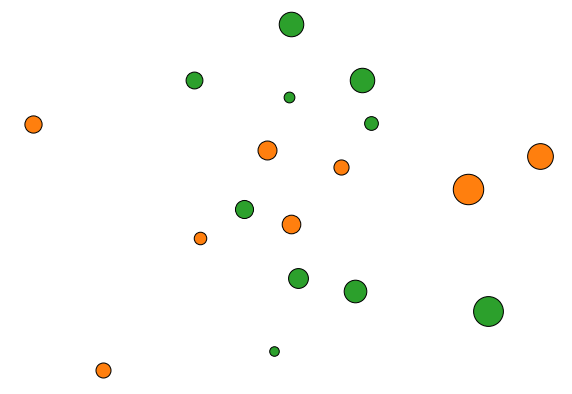

In [5]:
plt.figure(figsize = (10,7))
plt.axis("off")

for i in range(len(a)):
    myplot(X[i,0], X[i,1], a[i]*len(a)*20, c1)
    
for j in range(len(b)):
    myplot(Y[j,0], Y[j,1], b[j]*len(b)*20, c2)
    
plt.show()

We compute the cost matrix $C_{ij} := \norm{x_i-y_j}^p$ for whatever $p$ we want, but we will use $p=2$ by default.

In [6]:
def distance_matrix(x, y, p=2):
    return np.linalg.norm(x[:,np.newaxis] - y, axis=-1)**p

C = distance_matrix(X,Y,2)

# First we compute the Linear Programming (LP) solution

Use the code below to compute optimal transport plans using LP. Later we'll use it to compare Sinkhorn's method to the "objective truth" given by the LP solution

In [7]:
def solve_OT_LP(a_loc, b_loc, C_loc):

    n_loc = len(a_loc)
    m_loc = len(b_loc)
    
    S = scipy.sparse.lil_matrix((n_loc, n_loc * m_loc), dtype=np.int8)
    T = scipy.sparse.lil_matrix((m_loc, n_loc * m_loc), dtype=np.int8)

    for i in range(n_loc):
        S[i, i*m_loc:(i+1)*m_loc] = 1

    for i in range(n_loc):
        T[:, i*m_loc:(i+1)*m_loc] = scipy.sparse.eye(m_loc, format='lil')

    A_eq = scipy.sparse.vstack([S, T])
    b_eq = np.hstack([a_loc, b_loc])
    c = C_loc.flatten()

    results = scipy.optimize.linprog(c, A_ub=None, b_ub=None, A_eq=A_eq, b_eq=b_eq, options={'sparse':True})

    P = results.x.reshape((n_loc, m_loc))

    primal_min = results.fun
    return primal_min, P

def solve_OT_LP_dual(a_loc, b_loc, C_loc):
    
    n_loc = len(a_loc)
    m_loc = len(b_loc)
    
    S = scipy.sparse.lil_matrix((n_loc, n_loc * m_loc), dtype=np.int8)
    T = scipy.sparse.lil_matrix((m_loc, n_loc * m_loc), dtype=np.int8)

    for i in range(n_loc):
        S[i, i*m_loc:(i+1)*m_loc] = 1

    for i in range(n_loc):
        T[:, i*m_loc:(i+1)*m_loc] = scipy.sparse.eye(m_loc, format='lil')

    # Check dual problem
    c = -np.hstack([a, b])
    A_ub = scipy.sparse.vstack([S, T]).T
    b_ub = C.flatten()

    results = scipy.optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=(None, None), options={'sparse':True})

    dual_min = -results.fun
    #P = results.x.reshape((n_loc, m_loc))
    f = results.x[:n_loc]
    g = results.x[n_loc:]

    return dual_min, f, g

primal_min_soln, P_LP = solve_OT_LP(a, b, C)
dual_min_soln, f_LP, g_LP = solve_OT_LP_dual(a, b, C)

print(primal_min_soln)
print(dual_min_soln)

3.768175175522983
3.768175154475003


/usr/local/lib/python3.9/site-packages/scipy/optimize/_linprog_util.py:832: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning, stacklevel=1)


# Plot the optimal transport plan

The thickness of the lines between points is proportional to the amount of mass that should be transported.

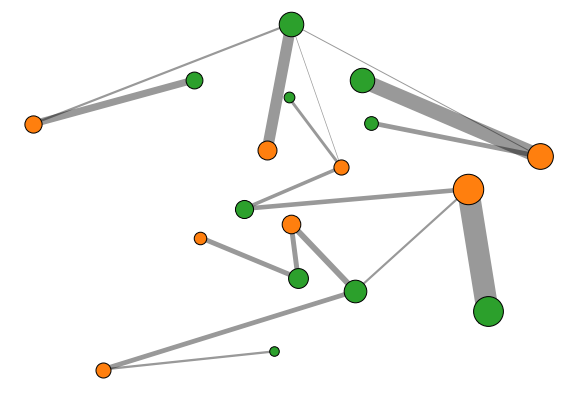

In [8]:
tol = 1e-8
I, J = np.nonzero(P_LP > tol)

plt.figure(figsize = (10,7))
plt.axis('off')

for i in range(len(a)):
    myplot(X[i,0], X[i,1], a[i]*len(a)*20, c1)
for j in range(len(b)):
    myplot(Y[j,0], Y[j,1], b[j]*len(b)*20, c2)
    
# Plot the lines between the points when there is a nonzero amount in the coupling between points
# Note that in this plot, the lines are proportional to the amount of mass coupled from a to b.
for k in range(len(I)):
    h = plt.plot(np.hstack((X[I[k],0],Y[J[k],0])),np.hstack(([X[I[k],1], Y[J[k],1]])),'k', lw = 100*P_LP[I[k], J[k]], alpha=0.4, zorder=0)
plt.show()

# Entropic Regularization of the Optimal Transport problem

Lets solve the regularized transport problem, 

$$  L_C^\epsilon(a,b) = \umin{P \in U(a,b)} \dotp{C}{P}_F - \epsilon H(P).  $$

where the polytope of couplings that have the vectors $a$ and $b$ as marginals is defined as

$$ U(a,b) = \enscond{P \in (\RR^+)^{n \times m}}{ P \mathbb{1}_m = a, P^\top \mathbb{1}_n = b },  $$

where $\mathbb{1}_n = (1,\ldots,1)^\top \in \RR^n $, and for $P \in \RR_+^{n \times m}$, we define its entropy as

$$ H(P) = -\sum_{ij} P_{ij} ( \log(P_{ij}) - 1). $$


The regularised transportation problem can be re-written as a projection of the Gibbs kernel $K$ in terms of the Kullback-Leibler divergence.

$$ L_C^\epsilon(a,b) = \epsilon \umin{P \in U(a,b)} \KLdiv{P}{K}
	\qwhereq
	K_{ij} = e^{ -\frac{C_{ij}}{\epsilon} }  $$
    

In this setting the Kullback-Leibler divergence between $P, K \in \RR_+^{n \times m}$ is

$$ 
\KLdiv{P}{K} = \sum_{ij} P_{ij} \pa{ \log\pa{ \frac{P_{ij}}{K_{ij}} } - 1} + K_{ij}.
$$


Given a convex set $\Cc \subset \RR^N$, the projection with respect to the Kullback-Leiber divergence is defined as

$$ \KLproj_\Cc(\xi) = \uargmin{ \pi \in \Cc } \KLdiv{\pi}{\xi}. $$

## Sinkhorn's Algorithm

A fundamental property of the optimal coupling $P^\epsilon$ is that it necessarily has the form 

$$
P^\epsilon = \diag{u} K \diag{v}
$$

where the $K$ is the Gibbs kernel defined earlier.

One thus needs to find two positive scaling vectors $u \in \RR_+^n$ and $v \in \RR_+^m$ such that the two following equality holds

$$
P \mathbb{1}_m  = u \odot (K v) = a 
\qandq
P^\top \mathbb{1}_n  = v \odot (K^\top u) = b.
$$

where $\odot$ denotes element-wise multiplication.

Sinkhorn's algorithm alternate between the resolution of these two equations, and reads

$$
u_{n+1} = \frac{a}{K v_n} \qandq v_{n+1} = \frac{b}{K^\top u_{n+1}}.
$$

where the division above is element-wise. This algorithm was shown to converge to a solution of the entropic regularised problem by Cuturi.

According to **Remark 4.6** in Peyré and Cuturi, we can estimate the error of $P^\epsilon$ from a valid coupling $\hat P$ by evaluating

$$
\| a -  u_{n+1} \odot (Kv_{n+1}) \|_1 + \| b - v_n \odot (K^T u_{n+1}) \|_1
$$

The term $v_n$ is not a typo in the above equation. Because of the orders of updates, we would have $b = v_{n+1} \odot (K^T u_{n+1})$, which does not give us a helpful error estimate.

## Implement the Sinkhorn method

We implement it in a function called ```sinkhorns_method(a, b, K, num_iter)```, so you can call it with different values of $\epsilon$, and to compare the elapsed time to compute between the different methods. Code ```sinkhorns_method``` to return the values of $u$ (```u```) and $v$ (```v```), as well as the error_vectors ```err_a``` and ```err_b```

__Important__: The code stops Sinkhorn's method once the total error (as described above) goes below a certain amount, which here we take to be ```error_tol = 1e-4```. If the error tolerance hasn't been reached, then the method should terminate after ```max_iter``` iterations.

In [9]:
error_tol = 1e-4
max_iter = 10000

def sinkhorns_method(a, b, K, num_iter=max_iter):
    
    v = np.ones(m)

    u = a / (K @ v)
    r = v * (K.T @ u)
    
    v = b / (K.T @ u)
    s = u * (K @ v)
    
    err_a = np.zeros(num_iter)
    err_b = np.zeros(num_iter)
    
    err_a[0] = np.linalg.norm(s - a, 1)
    err_b[0] = np.linalg.norm(r - b, 1)

    i = 1
    while (err_a[i-1] > error_tol and err_b[i-1] > error_tol) and (i < num_iter):

        # sinkhorn step 1
        u = a / (K @ v)
        r = v * (K.T @ u)
        err_b[i] = np.linalg.norm(r - b, 1)

        # sinkhorn step 2
        v = b / (K.T @ u)
        s = u * (K @ v)
        err_a[i] = np.linalg.norm(s - a, 1)
        
        i += 1
    
    return u, v, err_a[:i], err_b[:i]

# We calculate ```P_e``` =$P_\varepsilon$ from ```K```, ```u``` and ```v```

(it's not hard!)

We call the ```sinkhorns_method``` routine with the correct arguments, and use the values of ```u``` and ```v``` returned to calculate ```P_e```.

In [10]:
epsilon = 1.0

K = np.exp(-C/epsilon)

u, v, err_a, err_b =  sinkhorns_method(a, b, K)

P_e = np.diag(u) @ K @ np.diag(v)

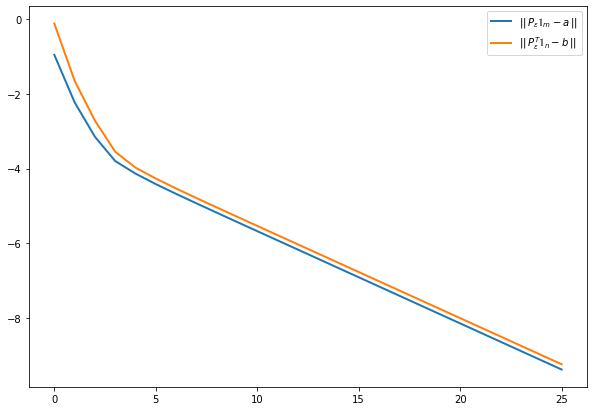

In [23]:
plt.figure(figsize = (10,7))
plt.plot(np.log(np.asarray(err_a)), linewidth = 2, label=r'$|| \, P_\varepsilon \mathbb{1}_m - a \,||$')
plt.plot(np.log(np.asarray(err_b)), linewidth = 2, label=r'$|| \, P_\varepsilon^T \mathbb{1}_n - b \,||$')
plt.legend()
plt.show()

### Plot the coupling

We can plot the coupling graphically using lines with thickness proportional to the amount of mass transfer, and do a simple greyscale density plot as well.

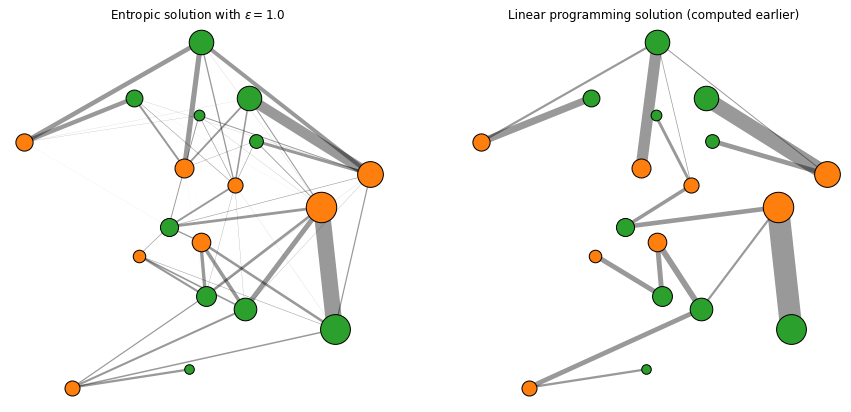

In [24]:
#plt.figure(figsize = (15,7))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,7))
ax1.axis('off')
ax2.axis('off')

for i in range(len(a)):
    myplot(X[i,0], X[i,1], a[i]*len(a)*20, c1, ax=ax1)
    myplot(X[i,0], X[i,1], a[i]*len(a)*20, c1, ax=ax2)
for j in range(len(b)):
    myplot(Y[j,0], Y[j,1], b[j]*len(b)*20, c2, ax=ax1)
    myplot(Y[j,0], Y[j,1], b[j]*len(b)*20, c2, ax=ax2)

# Plot the lines between the points when there is a nonzero amount in the coupling between points
# Note that in this plot, the lines are proportional to the amount of mass coupled from a to b.
tol = 1e-8
I, J = np.nonzero(P_e > tol)
for k in range(len(I)):
    h = ax1.plot(np.hstack((X[I[k],0],Y[J[k],0])),np.hstack(([X[I[k],1], Y[J[k],1]])),'k', lw = 100*P_e[I[k], J[k]], alpha=0.4, zorder=0)

I, J = np.nonzero(P_LP > tol)
for k in range(len(I)):
    h = ax2.plot(np.hstack((X[I[k],0],Y[J[k],0])),np.hstack(([X[I[k],1], Y[J[k],1]])),'k', lw = 100*P_LP[I[k], J[k]], alpha=0.4, zorder=0)

ax1.set_title(rf'Entropic solution with $\varepsilon={epsilon}$')
ax2.set_title(rf'Linear programming solution (computed earlier)')
plt.show()

# Define a convenient function ```solve_OT_sinkhorns``` 

It computes the coupling and the minimum given the inputs of $a$, $b$, $C$ and $\epsilon$.

In particular - calculate $P$ in ```P_loc``` using the results from ```sinkhorns_method```, and then calculate the entropic "Wasserstein distance" based on that coupling, that is, given ```P_loc```, calculate the total transport distance associated with it.

In [25]:
def solve_OT_sinkhorns(a_loc, b_loc, C_loc, epsilon=0.1):

    K_loc = np.exp(-C_loc/epsilon)
    
    u, v, err_a, err_b = sinkhorns_method(a_loc, b_loc, K_loc, 2000)
    
    P_loc = np.diag(u) @ K_loc @ np.diag(v)
    
    W_eps = (C_loc * P_loc).sum() # - epsilon * (P_loc * (np.log(P_loc) - 1)).sum()
    
    return W_eps, P_loc

Now we compare the entropic Wasserstein distances obtained from the Sinkhorn method with the "ground truth" Wasserstein distances obtained from the linear programming approach, both in primal and dual form.

In [26]:
epsilons = [2., 1., 0.5, 0.2, 0.1]

W_primal, P = solve_OT_LP(a, b, C)
W_dual, f, g = solve_OT_LP_dual(a, b, C)

W_eps = np.zeros(len(epsilons))
P_eps = np.zeros((len(epsilons),) + P.shape)
for i, eps in enumerate(epsilons):
    W_eps[i], P_eps[i] = solve_OT_sinkhorns(a, b, C, epsilon=eps)

print(f'Primal LP, W(a,b) = {W_primal}\n')
print(f'Dual LP, W(a,b) = {W_dual}\n')
for eps, W in zip(epsilons, W_eps):
    print(f'Sinkhorn, epsilon = {eps}, W_eps(a,b)={W}')

Primal LP, W(a,b) = 3.768175175522983

Dual LP, W(a,b) = 3.768175154475003

Sinkhorn, epsilon = 2.0, W_eps(a,b)=4.552718918104331
Sinkhorn, epsilon = 1.0, W_eps(a,b)=4.139887123622532
Sinkhorn, epsilon = 0.5, W_eps(a,b)=3.901720309235587
Sinkhorn, epsilon = 0.2, W_eps(a,b)=3.7883495689000766
Sinkhorn, epsilon = 0.1, W_eps(a,b)=3.77001323782482


/usr/local/lib/python3.9/site-packages/scipy/optimize/_linprog_util.py:832: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning, stacklevel=1)


### We plot the change in the coupling $P^\epsilon$ from $\epsilon = 2$ to $\epsilon = 0.1$

In the plot below, the blue edge corresponds edges $(i, j)$ given by $P^\epsilon_{ij}$ for which we also have $P_{ij} > 0$. The red edges are those for which $P^\epsilon_{ij} > 0$ but $P_{i,j} = 0$ (to within a tolerance, of course, which here is ```tol = 1e-8```.

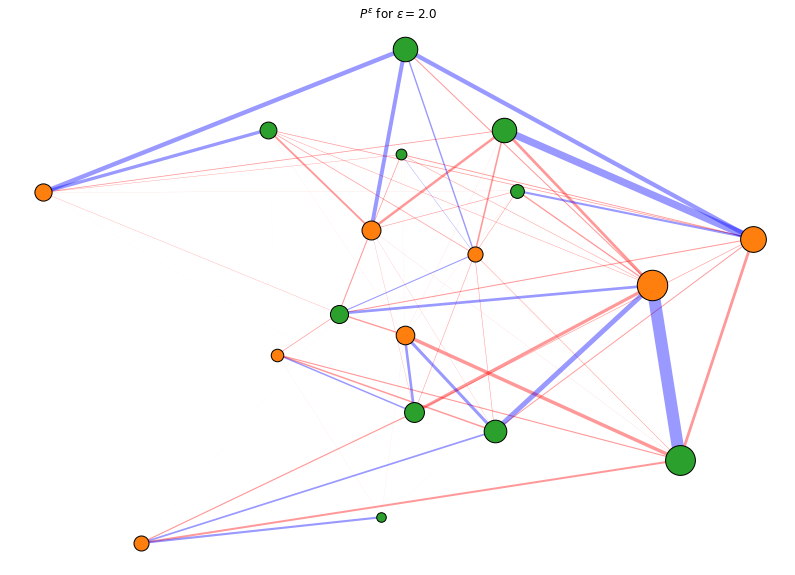

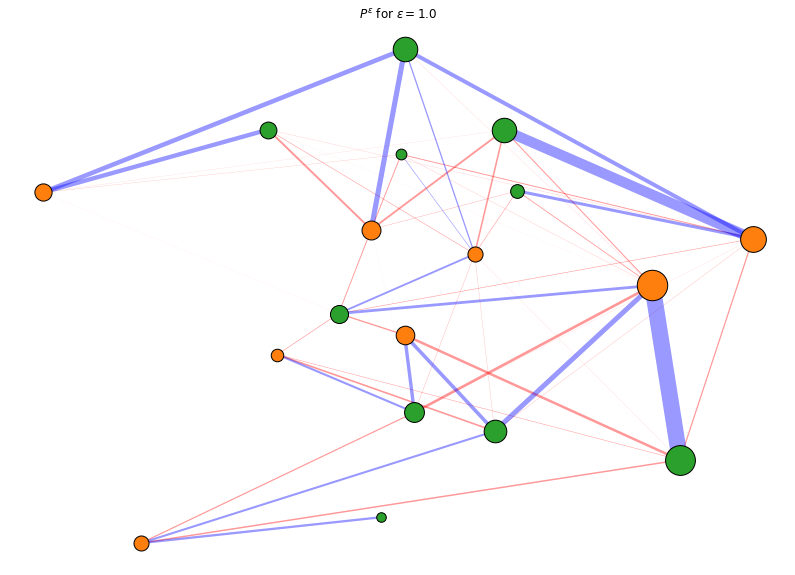

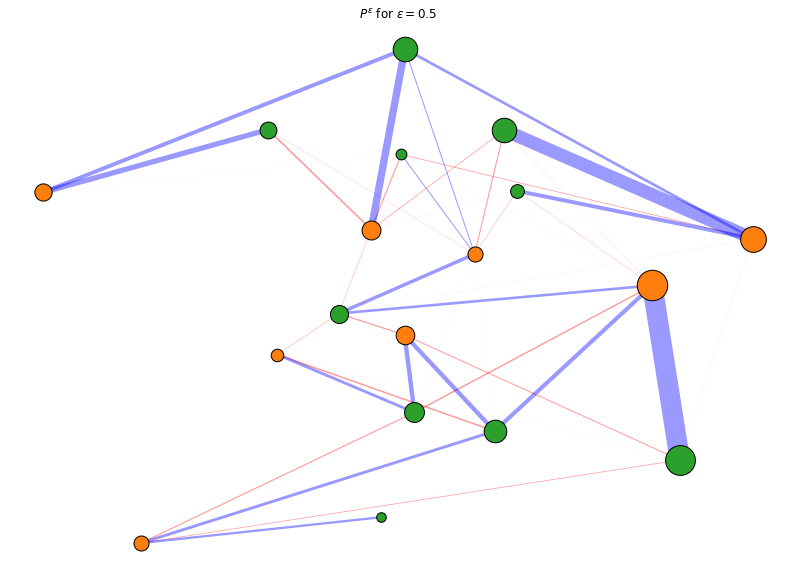

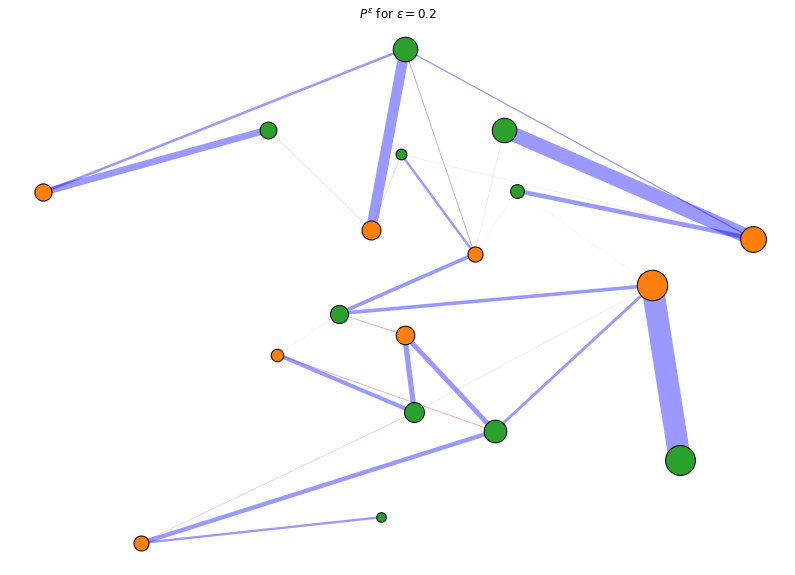

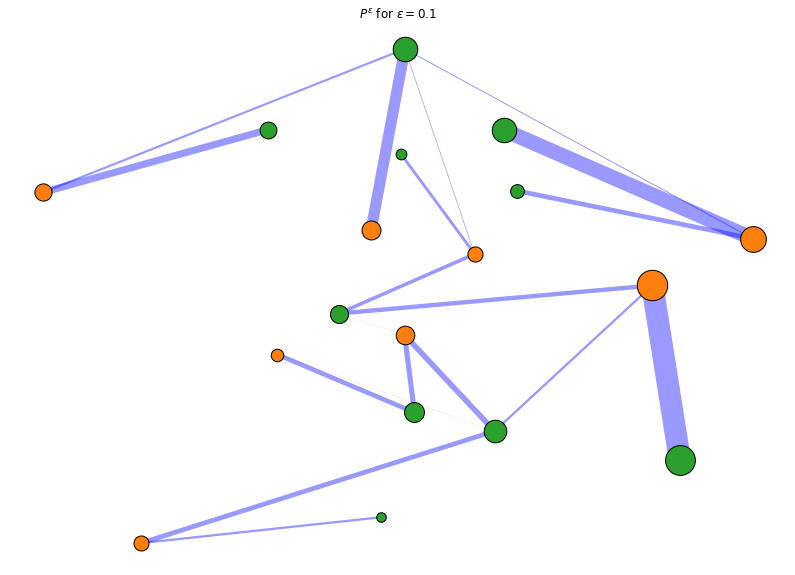

In [27]:
tol = 1e-8

for l in range(len(epsilons)):
    
    plt.figure(figsize = (14,10))
    plt.axis('off')
    
    for i in range(len(a)):
        myplot(X[i,0], X[i,1], a[i]*len(a)*20, c1)
    for j in range(len(b)):
        myplot(Y[j,0], Y[j,1], b[j]*len(b)*20, c2)

    P_eps_excess = P_eps[l] * (P < tol)
    P_eps_insuff = P_eps[l] * (P >= tol)
    
    I, J = np.nonzero(P_eps_excess > tol)
    for k in range(len(I)):
        h = plt.plot(np.hstack((X[I[k],0],Y[J[k],0])),np.hstack(([X[I[k],1], Y[J[k],1]])),'r', lw = 100*P_eps_excess[I[k], J[k]], alpha=0.4, zorder=0)
    
    I, J = np.nonzero(P_eps_insuff > tol)
    for k in range(len(I)):
        h = plt.plot(np.hstack((X[I[k],0],Y[J[k],0])),np.hstack(([X[I[k],1], Y[J[k],1]])),'b', lw = 100*P_eps_insuff[I[k], J[k]], alpha=0.4, zorder=0)
    plt.title(f'$P^\epsilon$ for $\epsilon = ${epsilons[l]}')
    plt.show()

# Make a fancy GIF of entropic OT

In [16]:
epsilons = [2., 1.75, 1.5, 1.25, 1., 0.75, 0.5, 0.25, 0.2, 0.15, 0.125, 0.1]

W_eps = np.zeros(len(epsilons))
P_eps = np.zeros((len(epsilons),) + P.shape)
for i, eps in enumerate(epsilons):
    W_eps[i], P_eps[i] = solve_OT_sinkhorns(a, b, C, epsilon=eps)

print(f'Primal LP, W(a,b) = {W_primal}\n')
print(f'Dual LP, W(a,b) = {W_dual}\n')
for eps, W in zip(epsilons, W_eps):
    print(f'Sinkhorn, epsilon = {eps}, W_eps(a,b)={W}')

Primal LP, W(a,b) = 3.768175175522983

Dual LP, W(a,b) = 3.768175154475003

Sinkhorn, epsilon = 2.0, W_eps(a,b)=4.552718918104331
Sinkhorn, epsilon = 1.75, W_eps(a,b)=4.457470394732998
Sinkhorn, epsilon = 1.5, W_eps(a,b)=4.357375783336235
Sinkhorn, epsilon = 1.25, W_eps(a,b)=4.251808713757076
Sinkhorn, epsilon = 1.0, W_eps(a,b)=4.139887123622532
Sinkhorn, epsilon = 0.75, W_eps(a,b)=4.021333008273727
Sinkhorn, epsilon = 0.5, W_eps(a,b)=3.901720309235587
Sinkhorn, epsilon = 0.25, W_eps(a,b)=3.8034453219801305
Sinkhorn, epsilon = 0.2, W_eps(a,b)=3.7883495689000766
Sinkhorn, epsilon = 0.15, W_eps(a,b)=3.776502604294214
Sinkhorn, epsilon = 0.125, W_eps(a,b)=3.7725512482387957
Sinkhorn, epsilon = 0.1, W_eps(a,b)=3.77001323782482


In [17]:
import imageio
import os

filenames = []

for l in range(len(epsilons)):
    
    plt.figure(figsize = (10,7))
    plt.axis('off')
    
    for i in range(len(a)):
        myplot(X[i,0], X[i,1], a[i]*len(a)*10, c1)
    for j in range(len(b)):
        myplot(Y[j,0], Y[j,1], b[j]*len(b)*10, c2)

    P_eps_excess = P_eps[l] * (P < tol)
    P_eps_insuff = P_eps[l] * (P >= tol)
    
    I, J = np.nonzero(P_eps_excess > tol)
    for k in range(len(I)):
        h = plt.plot(np.hstack((X[I[k],0],Y[J[k],0])),np.hstack(([X[I[k],1], Y[J[k],1]])),'r', lw = 100*P_eps_excess[I[k], J[k]], alpha=0.4, zorder=0)
    
    I, J = np.nonzero(P_eps_insuff > tol)
    for k in range(len(I)):
        h = plt.plot(np.hstack((X[I[k],0],Y[J[k],0])),np.hstack(([X[I[k],1], Y[J[k],1]])),'b', lw = 150*P_eps_insuff[I[k], J[k]], alpha=0.5, zorder=0)
    plt.title(f'Entropic OT coupling $P^\epsilon$ for $\epsilon = ${epsilons[l]:0.2f}\t')
    
    # create file name and append it to a list
    filename = f'{epsilons[l]}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename, dpi=150)
    plt.close()

images = []

#with imageio.get_writer('entropic_OT.gif', mode='I') as writer:
    #writer.append_data(image)
    
for filename in filenames:
        images.append(imageio.imread(filename))

        
for filename in filenames[::-1]:
        images.append(imageio.imread(filename))
    
# Remove files
#for filename in set(filenames):
#    os.remove(filename)

In [18]:
# build a gif

durs = [0.25,]*len(images)
durs[0] = 0.75
durs[len(filenames)] = 0.75
imageio.mimsave('entropic_OT.gif', images, duration = durs, palettesize=256)

# Test the speed of the different approaches

So what's all the fuss about? The speed of Sinkhorn's method of course!

Lets test the speed of the different methods of solution. Test the speed of the regularised solution for all different values of $\epsilon$.

The gains aren't enormous in this example, but they would be with a much _larger_ OT problem (where $n,m \sim 100$ or more), where the scaling of the problem matters. Nevertheless, the speed gain here is already impressive. 

In [28]:
import time

num_repeats = 100
t = np.zeros(len(epsilons)+3)

t[0] = time.time()
for j in range(num_repeats):
    W_primal, P = solve_OT_LP(a, b, C)

t[1] = time.time()
for j in range(num_repeats):
    W_dual, f, g = solve_OT_LP_dual(a, b, C)

t[2] = time.time()
for i, eps in enumerate(epsilons):
    for j in range(num_repeats):
        W_eps[i], P_eps[i] = solve_OT_sinkhorns(a, b, C, epsilon=eps)
        
    t[i+3] = time.time()

/usr/local/lib/python3.9/site-packages/scipy/optimize/_linprog_util.py:832: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning, stacklevel=1)


In [29]:
print(rf'Primal LP solving time: {t[1] - t[0]}')
print(rf'Dual LP solving time: {t[2] - t[1]}')
for i, eps in enumerate(epsilons):
    print(rf'Entropic / Sinkhorn solving time, eps={eps}: {t[i+3] - t[i+2]}')

Primal LP solving time: 2.713073968887329
Dual LP solving time: 1.9995200634002686
Entropic / Sinkhorn solving time, eps=2.0: 0.024447917938232422
Entropic / Sinkhorn solving time, eps=1.0: 0.04924297332763672
Entropic / Sinkhorn solving time, eps=0.5: 0.1107339859008789
Entropic / Sinkhorn solving time, eps=0.2: 0.2618720531463623
Entropic / Sinkhorn solving time, eps=0.1: 0.5327348709106445
